# K-Means Exploration
Exploratory notebook for working on birdnet embeddings

### Imports and Setup

In [1]:
import pandas as pd
import os
import numpy as np
from annotation_post_processing import *

In [2]:
embeddingColumns = [str(i) for i in range(420)]
columnNames = ["START", "END"] + embeddingColumns
path = './input/xc_embeddings/'

In [3]:
def generate_embeddings_from_file(path, filename):
    with open(path + filename, 'r') as f:
        data = f.read()
    with open(path + filename, 'w') as f:
        f.write(",".join(data.split("\t")))
    file_df = pd.read_csv(path + filename, names = columnNames)
    file_df["IN FILE"] = filename[:filename.index(".birdnet")] + ".wav"
    return file_df

def generate_embeddings(path):
    df = pd.DataFrame()
    for filename in os.listdir(path):
        try:
            df = pd.concat([df, generate_embeddings_from_file(path, filename)], ignore_index = True)
        except Exception as e:
            print("Something went wrong with: " + filename)
    df["PATH"] = path
    columns = df.columns.tolist()
    columns = columns[-2:] + columns[:-2]
    df = df[columns]
    df = df.sort_values(["IN FILE", "START"], ascending = True)
    df = df.reset_index(drop = True)
    return df

In [4]:
embeddings_df = generate_embeddings(path)
annotations_df = pd.read_csv("xc_annotations.csv")

# removing duplicate annotations
grouped_annotations = annotations_df.groupby(["IN FILE", "OFFSET"])["CONFIDENCE"].max()
annotations_df["MANUAL ID"] = annotations_df.apply(lambda x: x["MANUAL ID"] \
    if grouped_annotations.loc[x["IN FILE"], x["OFFSET"]] == x["CONFIDENCE"] else pd.NA, axis = 1)
annotations_df = annotations_df.dropna(subset = ["MANUAL ID"]).reset_index(drop = True)

In [5]:
manual_df = pd.read_csv("mixed_bird_manual.csv")
manual_df = pd.DataFrame(annotation_chunker(manual_df, 3))
manual_df["MANUAL ID"] = manual_df["MANUAL ID"].apply(lambda x: " ".join(x.split(" ")[:2]))
manual_df

,IN FILE,CLIP LENGTH,CHANNEL,OFFSET,DURATION,SAMPLE RATE,MANUAL ID
0,Aburria-aburri-257423.wav,24.6335,0,0.0,3.0,44100,Aburria aburri
1,Aburria-aburri-257423.wav,24.6335,0,3.0,3.0,44100,Aburria aburri
2,Aburria-aburri-257423.wav,24.6335,0,6.0,3.0,44100,Aburria aburri
3,Aburria-aburri-257423.wav,24.6335,0,18.0,3.0,44100,Aburria aburri
4,Aburria-aburri-257423.wav,24.6335,0,21.0,3.0,44100,Aburria aburri
...,...,...,...,...,...,...,...
22019,Zonotrichia-capensis-377483.wav,18.2596,0,0.0,3.0,44100,Zonotrichia capensis
22020,Zonotrichia-capensis-377483.wav,18.2596,0,3.0,3.0,44100,Zonotrichia capensis
22021,Zonotrichia-capensis-377483.wav,18.2596,0,6.0,3.0,44100,Zonotrichia capensis
22022,Zonotrichia-capensis-377483.wav,18.2596,0,12.0,3.0,44100,Zonotrichia capensis


In [6]:
# Data cleaning to avoid file does not exist
intersection_files = list(set(embeddings_df["IN FILE"].unique()).intersection(set(annotations_df["IN FILE"])))
embeddings_df = embeddings_df[embeddings_df["IN FILE"].isin(intersection_files)]
annotations_df = annotations_df[annotations_df["IN FILE"].isin(intersection_files)]
manual_df = manual_df[manual_df["IN FILE"].isin(intersection_files)]

In [7]:
# Adding manual ids to embeddings
k = 0
def embed_id(x):
    filenames = manual_df["IN FILE"] == x["IN FILE"]
    offsets = np.isclose(manual_df["OFFSET"], x["START"])
    both = filenames & offsets
    if not np.any(both):
        return "No bird"
    return manual_df[both]["MANUAL ID"].iloc[0]

embeddings_df["MANUAL ID"] = embeddings_df.apply(embed_id, axis = 1)
embeddings_df["FILE SPECIES"] = embeddings_df["IN FILE"].apply(lambda x: " ".join(x.split("-")[:2]))

In [8]:
# To change all of the birdnet annotations manual ids to species names
birdnet_species = pd.read_csv("birdnet_species.csv")
birdnet_species.columns = ["SPECIES"]
birdnet_species = birdnet_species.assign(
    SPECIES = birdnet_species["SPECIES"].apply(lambda x: x.split("_")[0]), 
    COMMON = birdnet_species["SPECIES"].apply(lambda x: x.split("_")[1])
)
birdnet_species:dict = birdnet_species.set_index("COMMON").to_dict()["SPECIES"]

annotations_df["MANUAL ID"] = annotations_df["MANUAL ID"].apply(lambda x: birdnet_species[x] if x in birdnet_species.keys() else pd.NA)
annotations_df = annotations_df.dropna(subset = ["MANUAL ID"])

# Data cleaning to avoid file does not exist
intersection_files = list(set(embeddings_df["IN FILE"].unique()).intersection(set(annotations_df["IN FILE"].unique())).intersection(set(manual_df["IN FILE"].unique())))
embeddings_df = embeddings_df[embeddings_df["IN FILE"].isin(intersection_files)]
annotations_df = annotations_df[annotations_df["IN FILE"].isin(intersection_files)]
manual_df = manual_df[manual_df["IN FILE"].isin(intersection_files)]

In [9]:
embeddings_df

,IN FILE,PATH,START,END,0,1,2,3,4,5,...,412,413,414,415,416,417,418,419,MANUAL ID,FILE SPECIES
0,Aburria-aburri-257423.wav,./input/xc_embeddings/,0.0,3.0,0.506052,0.273989,0.180496,0.619193,0.600278,1.165174,...,1.003850,0.964111,0.606187,0.393715,0.422115,0.493174,0.442750,0.098618,Aburria aburri,Aburria aburri
1,Aburria-aburri-257423.wav,./input/xc_embeddings/,3.0,6.0,0.304604,0.657076,0.255976,0.360223,0.878593,0.947630,...,0.751940,0.567670,1.015642,0.183751,0.341058,0.292465,0.537704,0.462462,Aburria aburri,Aburria aburri
2,Aburria-aburri-257423.wav,./input/xc_embeddings/,6.0,9.0,0.564807,0.084755,0.302163,0.365694,0.455585,0.610926,...,0.599437,0.228005,0.550807,0.950302,0.251503,0.108405,0.434108,0.133058,Aburria aburri,Aburria aburri
3,Aburria-aburri-257423.wav,./input/xc_embeddings/,9.0,12.0,0.686421,0.036993,0.136615,0.194952,0.527402,0.759126,...,0.504211,1.144157,0.366139,0.540860,0.327322,0.620256,0.641296,0.329346,No bird,Aburria aburri
4,Aburria-aburri-257423.wav,./input/xc_embeddings/,12.0,15.0,0.417132,0.723672,0.482550,0.355739,0.267709,0.970670,...,0.198062,0.633536,0.475412,0.353786,0.210312,0.429860,0.634127,0.337614,No bird,Aburria aburri
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15730,Zonotrichia-capensis-47546.wav,./input/xc_embeddings/,39.0,42.0,0.831121,0.870642,1.753052,1.139851,0.319989,0.597747,...,1.256562,0.365584,1.060242,1.059041,1.211821,1.957344,0.980760,0.867312,No bird,Zonotrichia capensis
15731,Zonotrichia-capensis-47546.wav,./input/xc_embeddings/,42.0,45.0,0.785563,0.387962,1.788493,0.609213,1.146891,0.882367,...,0.557916,0.267391,1.037729,0.276864,0.347830,0.941056,0.915470,0.667181,Zonotrichia capensis,Zonotrichia capensis
15732,Zonotrichia-capensis-47546.wav,./input/xc_embeddings/,45.0,48.0,0.526084,0.329259,2.578663,0.929170,0.959224,1.478699,...,0.703093,0.428006,0.745683,0.439675,0.658591,1.064636,0.515144,0.334918,No bird,Zonotrichia capensis
15733,Zonotrichia-capensis-47546.wav,./input/xc_embeddings/,48.0,51.0,0.606348,0.775253,2.305807,0.905893,0.939975,1.225997,...,0.772524,0.464362,0.721824,0.358481,0.640352,0.976222,0.174749,0.666038,No bird,Zonotrichia capensis


In [10]:
annotations_df

,FOLDER,IN FILE,CLIP LENGTH,CHANNEL,OFFSET,DURATION,SAMPLE RATE,MANUAL ID,CONFIDENCE
0,../passive-acoustic-biodiversity/BirdnetEmbedd...,Aburria-aburri-257423.wav,53.623900,1,3.0,3.0,48000,Aburria aburri,0.9997
1,../passive-acoustic-biodiversity/BirdnetEmbedd...,Aburria-aburri-257423.wav,53.623900,1,6.0,3.0,48000,Aburria aburri,0.5550
2,../passive-acoustic-biodiversity/BirdnetEmbedd...,Aburria-aburri-257423.wav,53.623900,1,9.0,3.0,48000,Myiodynastes chrysocephalus,0.8600
3,../passive-acoustic-biodiversity/BirdnetEmbedd...,Aburria-aburri-257423.wav,53.623900,1,12.0,3.0,48000,Myiodynastes chrysocephalus,0.8412
4,../passive-acoustic-biodiversity/BirdnetEmbedd...,Aburria-aburri-257423.wav,53.623900,1,15.0,3.0,48000,Myiodynastes chrysocephalus,0.3520
...,...,...,...,...,...,...,...,...,...
13784,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zonotrichia-capensis-47546.wav,119.587528,1,33.0,3.0,48000,Bubo bubo,0.2220
13785,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zonotrichia-capensis-47546.wav,119.587528,1,42.0,3.0,48000,Zonotrichia capensis,0.9373
13786,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zonotrichia-capensis-47546.wav,119.587528,1,45.0,3.0,48000,Zonotrichia capensis,0.7524
13787,../passive-acoustic-biodiversity/BirdnetEmbedd...,Zonotrichia-capensis-47546.wav,119.587528,1,48.0,3.0,48000,Zonotrichia capensis,0.4010


In [11]:
manual_df

,IN FILE,CLIP LENGTH,CHANNEL,OFFSET,DURATION,SAMPLE RATE,MANUAL ID
0,Aburria-aburri-257423.wav,24.6335,0,0.0,3.0,44100,Aburria aburri
1,Aburria-aburri-257423.wav,24.6335,0,3.0,3.0,44100,Aburria aburri
2,Aburria-aburri-257423.wav,24.6335,0,6.0,3.0,44100,Aburria aburri
3,Aburria-aburri-257423.wav,24.6335,0,18.0,3.0,44100,Aburria aburri
4,Aburria-aburri-257423.wav,24.6335,0,21.0,3.0,44100,Aburria aburri
...,...,...,...,...,...,...,...
22019,Zonotrichia-capensis-377483.wav,18.2596,0,0.0,3.0,44100,Zonotrichia capensis
22020,Zonotrichia-capensis-377483.wav,18.2596,0,3.0,3.0,44100,Zonotrichia capensis
22021,Zonotrichia-capensis-377483.wav,18.2596,0,6.0,3.0,44100,Zonotrichia capensis
22022,Zonotrichia-capensis-377483.wav,18.2596,0,12.0,3.0,44100,Zonotrichia capensis


In [12]:
# Checking to see if same number of files are in all of the dataframes
print(len(embeddings_df["IN FILE"].unique()), len(annotations_df["IN FILE"].unique()), len(manual_df["IN FILE"].unique()))

1256 1256 1256


### HDBSCAN

In [13]:
import hdbscan
from hdbscan import HDBSCAN
import pickle
import seaborn as sns

In [14]:
# Model trained on only embeddings that have a label from Manual ID
with open("./ClusteringModels/hdbscan_model.pkl", "rb") as f:
    hdbscan_model:HDBSCAN = pickle.load(f)

In [15]:
embeddings_df["HDBSCAN PREDICTIONS"] = hdbscan_model.labels_
embeddings_df

,IN FILE,PATH,START,END,0,1,2,3,4,5,...,413,414,415,416,417,418,419,MANUAL ID,FILE SPECIES,HDBSCAN PREDICTIONS
0,Aburria-aburri-257423.wav,./input/xc_embeddings/,0.0,3.0,0.506052,0.273989,0.180496,0.619193,0.600278,1.165174,...,0.964111,0.606187,0.393715,0.422115,0.493174,0.442750,0.098618,Aburria aburri,Aburria aburri,-1
1,Aburria-aburri-257423.wav,./input/xc_embeddings/,3.0,6.0,0.304604,0.657076,0.255976,0.360223,0.878593,0.947630,...,0.567670,1.015642,0.183751,0.341058,0.292465,0.537704,0.462462,Aburria aburri,Aburria aburri,-1
2,Aburria-aburri-257423.wav,./input/xc_embeddings/,6.0,9.0,0.564807,0.084755,0.302163,0.365694,0.455585,0.610926,...,0.228005,0.550807,0.950302,0.251503,0.108405,0.434108,0.133058,Aburria aburri,Aburria aburri,1519
3,Aburria-aburri-257423.wav,./input/xc_embeddings/,9.0,12.0,0.686421,0.036993,0.136615,0.194952,0.527402,0.759126,...,1.144157,0.366139,0.540860,0.327322,0.620256,0.641296,0.329346,No bird,Aburria aburri,1519
4,Aburria-aburri-257423.wav,./input/xc_embeddings/,12.0,15.0,0.417132,0.723672,0.482550,0.355739,0.267709,0.970670,...,0.633536,0.475412,0.353786,0.210312,0.429860,0.634127,0.337614,No bird,Aburria aburri,1519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15730,Zonotrichia-capensis-47546.wav,./input/xc_embeddings/,39.0,42.0,0.831121,0.870642,1.753052,1.139851,0.319989,0.597747,...,0.365584,1.060242,1.059041,1.211821,1.957344,0.980760,0.867312,No bird,Zonotrichia capensis,-1
15731,Zonotrichia-capensis-47546.wav,./input/xc_embeddings/,42.0,45.0,0.785563,0.387962,1.788493,0.609213,1.146891,0.882367,...,0.267391,1.037729,0.276864,0.347830,0.941056,0.915470,0.667181,Zonotrichia capensis,Zonotrichia capensis,1559
15732,Zonotrichia-capensis-47546.wav,./input/xc_embeddings/,45.0,48.0,0.526084,0.329259,2.578663,0.929170,0.959224,1.478699,...,0.428006,0.745683,0.439675,0.658591,1.064636,0.515144,0.334918,No bird,Zonotrichia capensis,1105
15733,Zonotrichia-capensis-47546.wav,./input/xc_embeddings/,48.0,51.0,0.606348,0.775253,2.305807,0.905893,0.939975,1.225997,...,0.464362,0.721824,0.358481,0.640352,0.976222,0.174749,0.666038,No bird,Zonotrichia capensis,1105


In [16]:
predicted_labels_hdbscan = embeddings_df[embeddings_df["MANUAL ID"] != "No bird"][["MANUAL ID", "HDBSCAN PREDICTIONS"]].groupby("MANUAL ID")["HDBSCAN PREDICTIONS"]
predicted_labels_hdbscan = predicted_labels_hdbscan.agg(pd.Series.mode)
predicted_labels_hdbscan = predicted_labels_hdbscan.apply(lambda x: int(x) if isinstance(x, int) else int(np.max(x)))
predicted_labels_hdbscan

MANUAL ID
Aburria aburri                       -1
Accipiter bicolor                    -1
Accipiter striatus                   -1
Actitis macularius                   -1
Adelomyia melanogenys               173
                                   ... 
Xiphocolaptes promeropirhynchus      -1
Xiphorhynchus guttatus             1119
Zenaida auriculata                   -1
Zentrygon frenata                  1795
Zonotrichia capensis                352
Name: HDBSCAN PREDICTIONS, Length: 475, dtype: int64

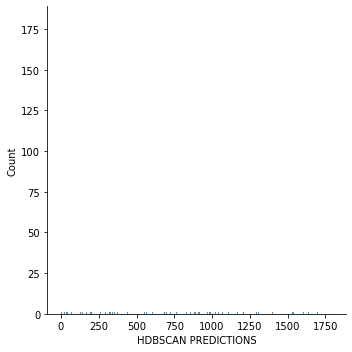

In [17]:
sns.displot(predicted_labels_hdbscan, binwidth = 1)

#### Conclusion
It seems as if many of the species are classified as noise, though there are also many correctly identified species. However, for the species that it is able to classify, it almost always has only 1 species per cluster number, which is better than KMeans.

In [18]:
embeddings_df["HDBSCAN PROBABILITIES"] = hdbscan_model.probabilities_
embeddings_df_above_thresh = embeddings_df[embeddings_df["HDBSCAN PROBABILITIES"] >= 0.5]
embeddings_df_above_thresh

,IN FILE,PATH,START,END,0,1,2,3,4,5,...,414,415,416,417,418,419,MANUAL ID,FILE SPECIES,HDBSCAN PREDICTIONS,HDBSCAN PROBABILITIES
2,Aburria-aburri-257423.wav,./input/xc_embeddings/,6.0,9.0,0.564807,0.084755,0.302163,0.365694,0.455585,0.610926,...,0.550807,0.950302,0.251503,0.108405,0.434108,0.133058,Aburria aburri,Aburria aburri,1519,0.853275
3,Aburria-aburri-257423.wav,./input/xc_embeddings/,9.0,12.0,0.686421,0.036993,0.136615,0.194952,0.527402,0.759126,...,0.366139,0.540860,0.327322,0.620256,0.641296,0.329346,No bird,Aburria aburri,1519,1.000000
4,Aburria-aburri-257423.wav,./input/xc_embeddings/,12.0,15.0,0.417132,0.723672,0.482550,0.355739,0.267709,0.970670,...,0.475412,0.353786,0.210312,0.429860,0.634127,0.337614,No bird,Aburria aburri,1519,1.000000
5,Aburria-aburri-257423.wav,./input/xc_embeddings/,15.0,18.0,0.356146,0.133322,0.499976,0.316470,0.059246,0.732283,...,0.278223,0.677732,0.114208,0.677371,0.703212,0.302993,No bird,Aburria aburri,1519,1.000000
8,Aburria-aburri-387212.wav,./input/xc_embeddings/,0.0,3.0,0.283399,0.832653,0.103618,1.061404,1.604393,0.981044,...,0.733464,0.654148,1.692423,0.653857,0.395016,0.788540,Aburria aburri,Aburria aburri,467,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15728,Zonotrichia-capensis-47546.wav,./input/xc_embeddings/,33.0,36.0,0.748323,0.000894,1.567416,0.381879,0.198716,1.064070,...,0.559075,0.448760,0.119536,0.272840,0.393462,0.122106,No bird,Zonotrichia capensis,1786,1.000000
15731,Zonotrichia-capensis-47546.wav,./input/xc_embeddings/,42.0,45.0,0.785563,0.387962,1.788493,0.609213,1.146891,0.882367,...,1.037729,0.276864,0.347830,0.941056,0.915470,0.667181,Zonotrichia capensis,Zonotrichia capensis,1559,1.000000
15732,Zonotrichia-capensis-47546.wav,./input/xc_embeddings/,45.0,48.0,0.526084,0.329259,2.578663,0.929170,0.959224,1.478699,...,0.745683,0.439675,0.658591,1.064636,0.515144,0.334918,No bird,Zonotrichia capensis,1105,1.000000
15733,Zonotrichia-capensis-47546.wav,./input/xc_embeddings/,48.0,51.0,0.606348,0.775253,2.305807,0.905893,0.939975,1.225997,...,0.721824,0.358481,0.640352,0.976222,0.174749,0.666038,No bird,Zonotrichia capensis,1105,1.000000


In [19]:
predicted_labels_hdbscan_above_thresh = embeddings_df[embeddings_df["MANUAL ID"] != "No bird"][["MANUAL ID", "HDBSCAN PREDICTIONS"]].groupby("MANUAL ID")["HDBSCAN PREDICTIONS"]
predicted_labels_hdbscan_above_thresh = predicted_labels_hdbscan_above_thresh.agg(pd.Series.mode)
predicted_labels_hdbscan_above_thresh = predicted_labels_hdbscan_above_thresh.apply(lambda x: int(x) if isinstance(x, int) else int(np.max(x)))
predicted_labels_hdbscan_above_thresh

MANUAL ID
Aburria aburri                       -1
Accipiter bicolor                    -1
Accipiter striatus                   -1
Actitis macularius                   -1
Adelomyia melanogenys               173
                                   ... 
Xiphocolaptes promeropirhynchus      -1
Xiphorhynchus guttatus             1119
Zenaida auriculata                   -1
Zentrygon frenata                  1795
Zonotrichia capensis                352
Name: HDBSCAN PREDICTIONS, Length: 475, dtype: int64

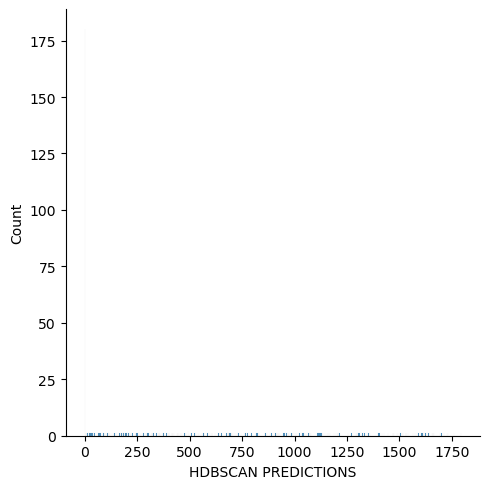

In [20]:
sns.displot(predicted_labels_hdbscan, binwidth = 1)

#### Conclusion
It seems as if many of the species are classified as noise (i.e. not much difference from when disregarding the threshold). However, for the species that it is able to classify, it almost always has only 1 species per cluster number, which is better than KMeans.

### Visualizations

In [21]:
%matplotlib inline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.preprocessing import LabelEncoder

plt.style.use("ggplot")

In [22]:
# Visualization for all models
pca_2d = PCA(n_components = 2, random_state = 42)
pca_columns_2d = pd.DataFrame(pca_2d.fit_transform(embeddings_df[embeddingColumns])).T
pca_3d = PCA(n_components = 3, random_state = 42)
pca_columns_3d = pd.DataFrame(pca_3d.fit_transform(embeddings_df[embeddingColumns])).T

Text(0.5, 1.0, 'PCA Visualization 2D with Manual ID labels')

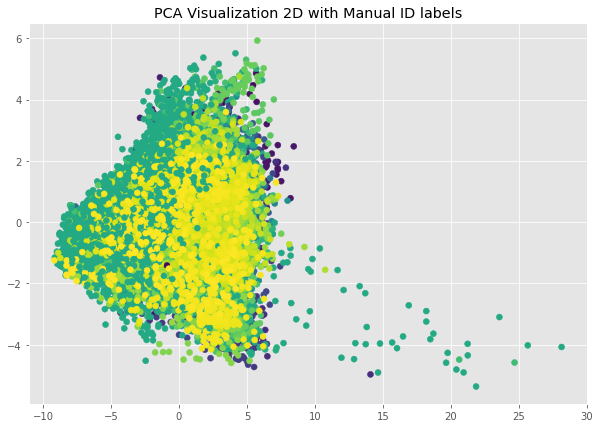

In [23]:
# Plotting 2D manual labels
fig = plt.figure(figsize = (10, 7))
ax = plt.axes()

embeddings_df["MANUAL ID NUMS"] = LabelEncoder().fit_transform(embeddings_df["MANUAL ID"])

# MANUAL ID labels
scatter_plot = ax.scatter(pca_columns_2d.iloc[0], pca_columns_2d.iloc[1], c = embeddings_df["MANUAL ID NUMS"])

plt.title("PCA Visualization 2D with Manual ID labels")

Text(0.5, 0.92, 'PCA Visualization 3D with Manual ID labels')

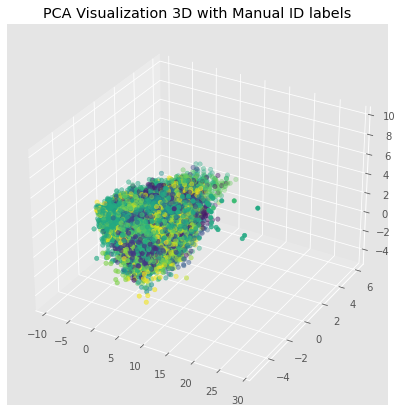

In [24]:
# Plotting 3D manual labels
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection = '3d')

# MANUAL ID labels
scatter_plot = ax.scatter(pca_columns_3d.iloc[0], pca_columns_3d.iloc[1], pca_columns_3d.iloc[2], c = embeddings_df["MANUAL ID NUMS"])

plt.title("PCA Visualization 3D with Manual ID labels")

Text(0.5, 1.0, 'PCA Visualization 2D with HDBSCAN labels')

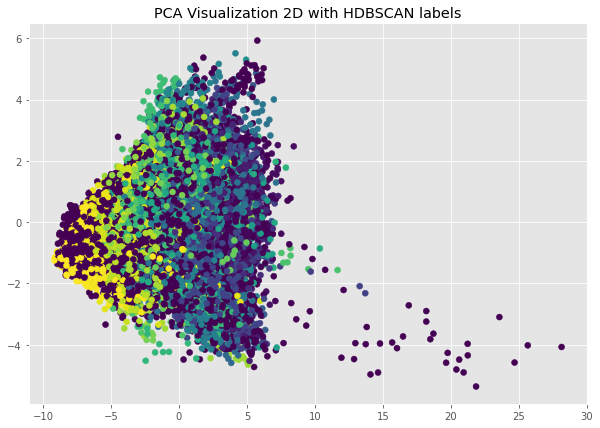

In [25]:
# Plotting 2D HDBSCAN labels
fig = plt.figure(figsize = (10, 7))
ax = plt.axes()

# HDBSCAN labels
scatter_plot = ax.scatter(pca_columns_2d.iloc[0], pca_columns_2d.iloc[1], c = embeddings_df["HDBSCAN PREDICTIONS"])

plt.title("PCA Visualization 2D with HDBSCAN labels")

Text(0.5, 0.92, 'PCA Visualization 3D with HDBSCAN labels')

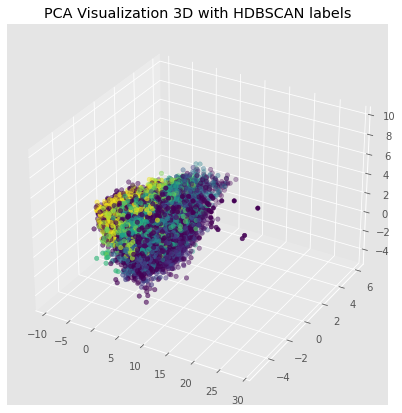

In [26]:
# Plotting 3D HDBSCAN labels
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection = '3d')

# HDBSCAN labels
scatter_plot = ax.scatter(pca_columns_3d.iloc[0], pca_columns_3d.iloc[1], pca_columns_3d.iloc[2], c = embeddings_df["HDBSCAN PREDICTIONS"])

plt.title("PCA Visualization 3D with HDBSCAN labels")

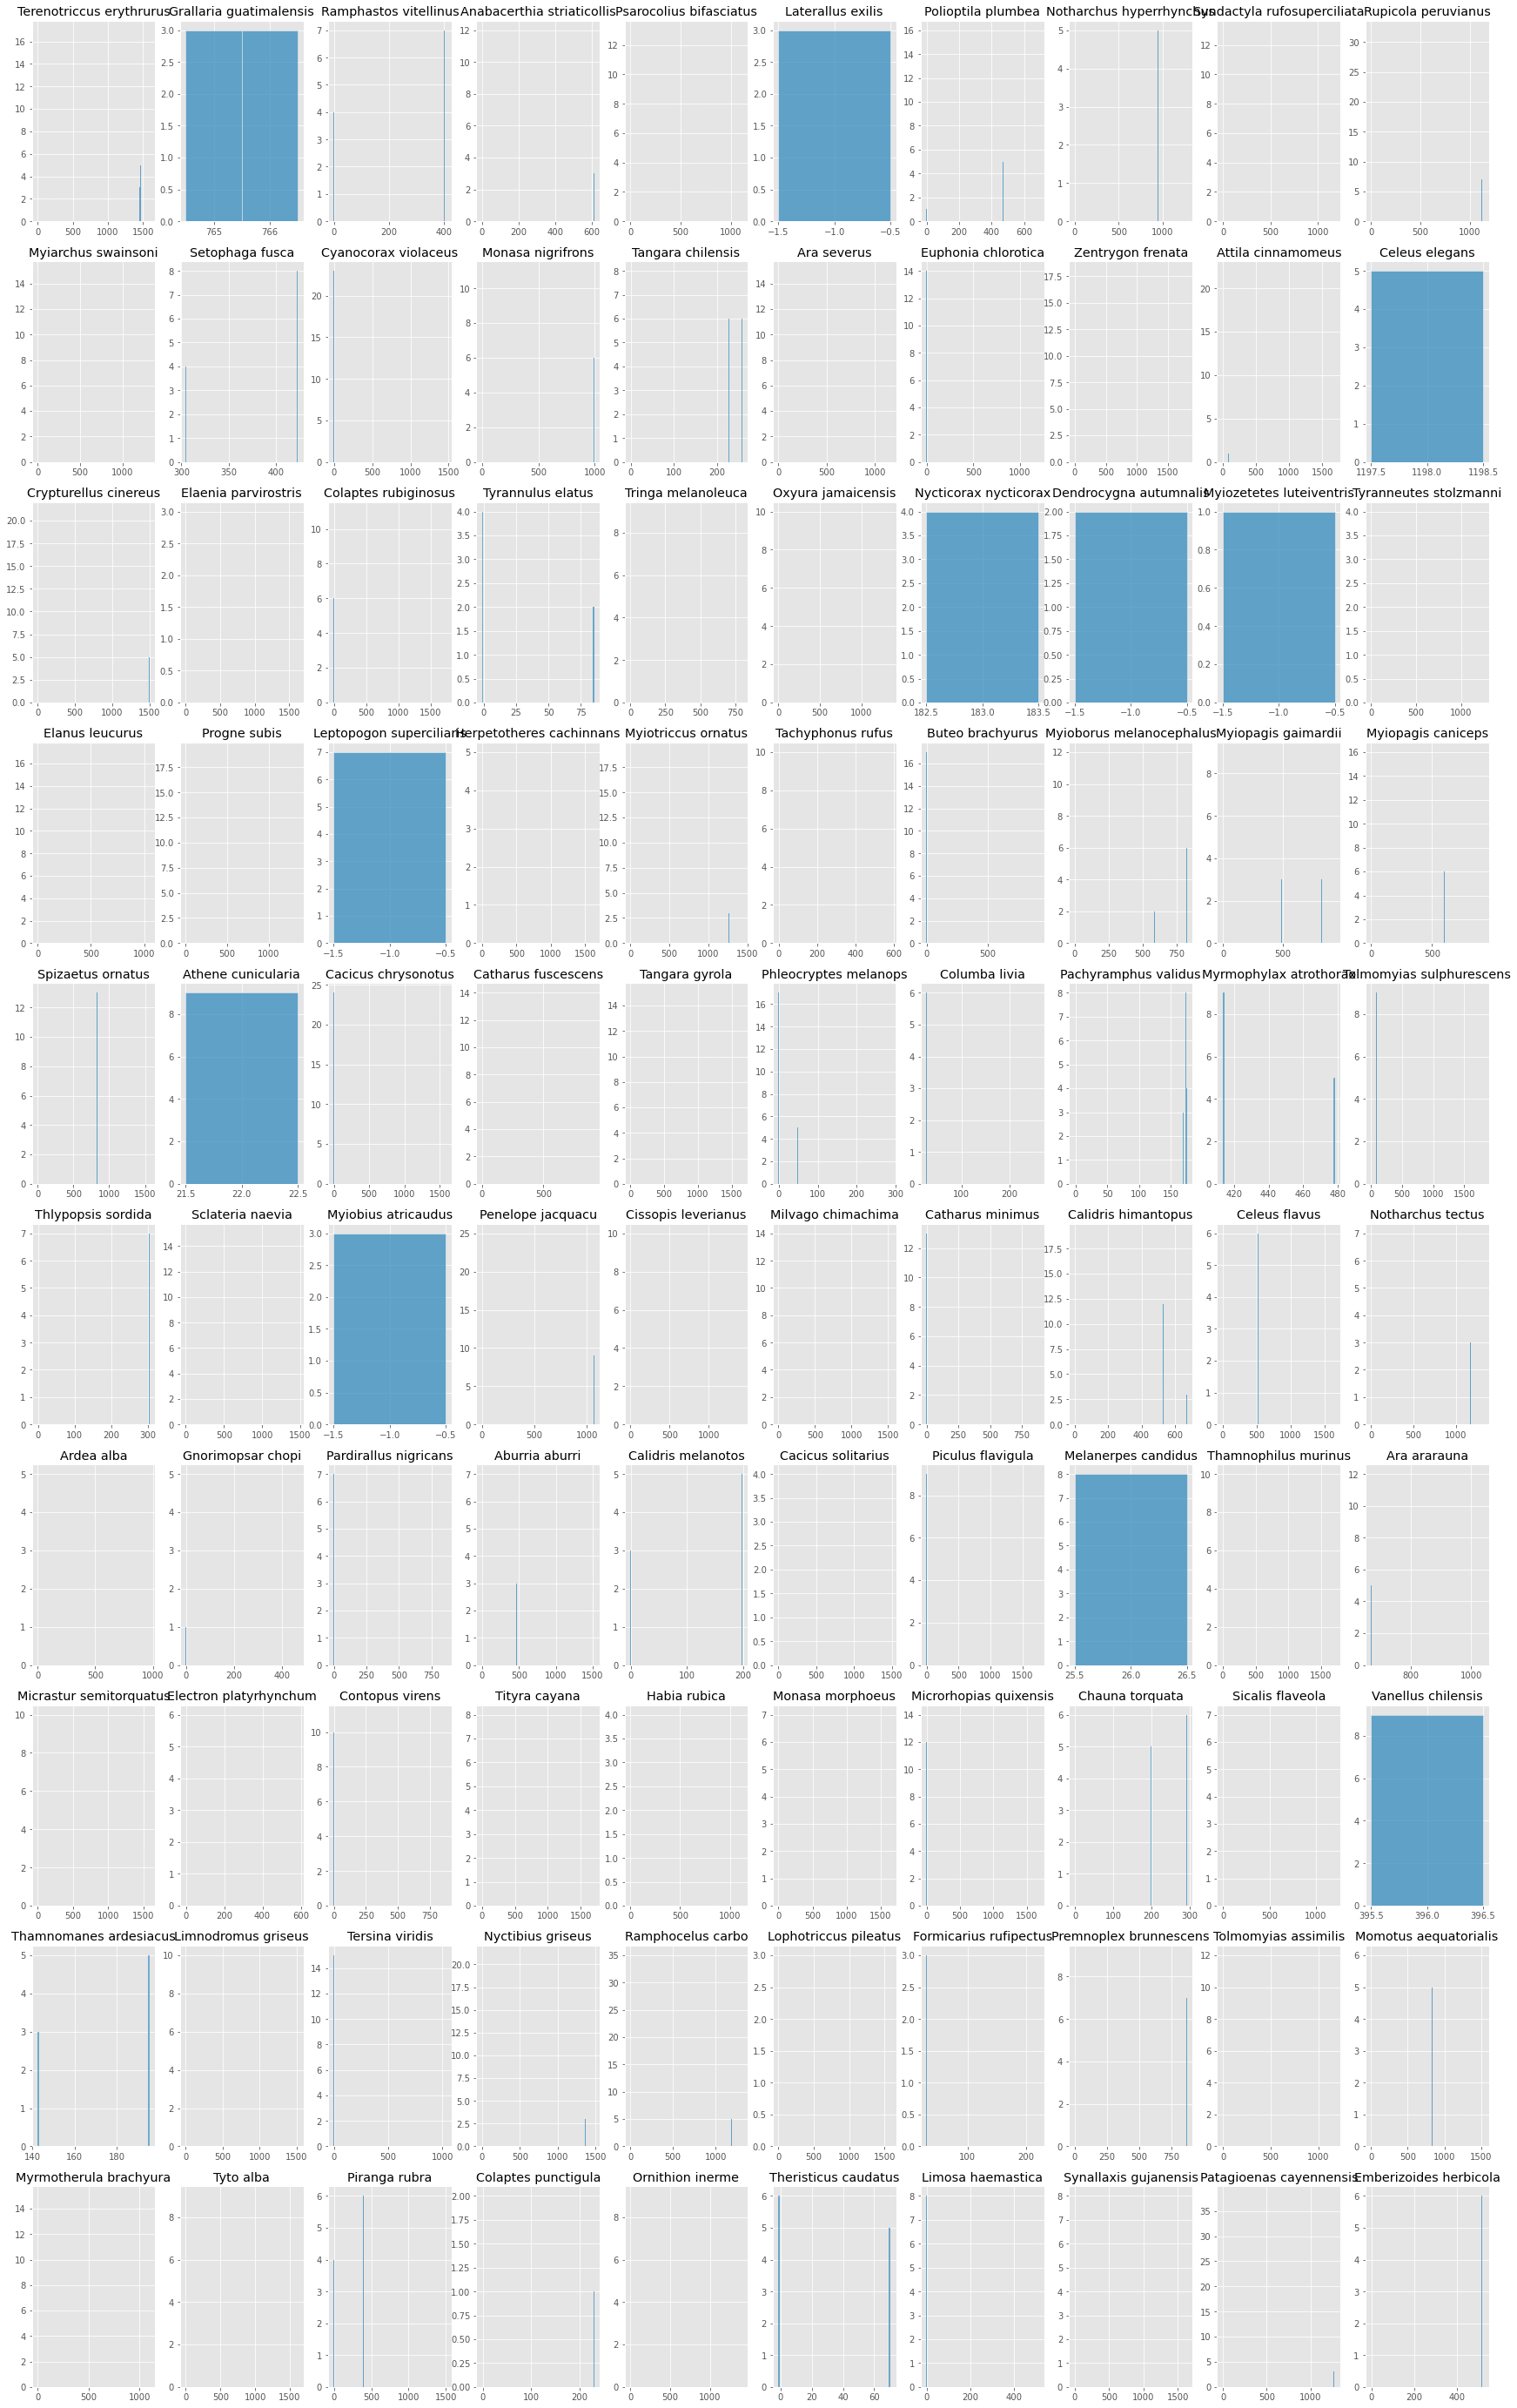

In [27]:
# Plotting each species separately
figure, axes = plt.subplots(10, 10, figsize = (30, 50), sharex = False)

x = 0
y = 0

sample = pd.Series(embeddings_df["MANUAL ID"].unique()).sample(100)
for species in sample:
    sns.histplot(ax = axes[x, y], data = embeddings_df[embeddings_df["MANUAL ID"] == species][["MANUAL ID", "HDBSCAN PREDICTIONS"]], x = "HDBSCAN PREDICTIONS", discrete = True).set(title = species, xlabel = "", ylabel = "")
    if x < 9:
        x += 1
    else:
        x = 0
        y += 1

### Statistics

In [28]:
# Self-written functions
# Printing precision and recall, for before HDBSCAN and after HDBSCAN
def global_stats(annotations: pd.DataFrame, manual: pd.DataFrame, embeddings: pd.DataFrame):
    statistics = pd.DataFrame({"Previous": [0, 0, 0, 0], "New": [0, 0, 0, 0]}, index = ["Precision", "Recall", "F1 Score", "# of Annotations"])
    TP_previous = annotations.apply(lambda x: ((manual["IN FILE"] == x["IN FILE"]) & np.isclose(manual["OFFSET"], x["OFFSET"]) & (manual["MANUAL ID"] == x["MANUAL ID"])).sum() != 0, axis = 1).sum()
    FP_previous = annotations.apply(lambda x: ((manual["IN FILE"] == x["IN FILE"]) & np.isclose(manual["OFFSET"], x["OFFSET"]) & (manual["MANUAL ID"] == x["MANUAL ID"])).sum() == 0, axis = 1).sum()
    FN_previous = manual.apply(lambda x: ((annotations["IN FILE"] == x["IN FILE"]) & np.isclose(annotations["OFFSET"], x["OFFSET"]) & (annotations["MANUAL ID"] == x["MANUAL ID"])).sum() == 0, axis = 1).sum()
    statistics["Previous"] = pd.Series([TP_previous / (TP_previous + FP_previous), TP_previous / (TP_previous + FN_previous), TP_previous / (TP_previous + 0.5 * (FP_previous + FN_previous)), \
        len(annotations.index)], index = ["Precision", "Recall", "F1 Score", "# of Annotations"])
    
    print("Finished old stats")
    
    filter = annotations.apply(lambda x: embeddings[(embeddings["IN FILE"] == x["IN FILE"]) & np.isclose(embeddings["START"], x["OFFSET"])]["HDBSCAN PREDICTIONS"], axis = 1)
    filter = (filter != -1).apply(np.prod, axis = 1).apply(bool)
    annotations_filtered = annotations[filter]
    
    print("Finished filtering")
    
    TP_new = annotations_filtered.apply(lambda x: ((manual["IN FILE"] == x["IN FILE"]) & np.isclose(manual["OFFSET"], x["OFFSET"]) & (manual["MANUAL ID"] == x["MANUAL ID"])).sum() != 0, axis = 1).sum()
    FP_new = annotations_filtered.apply(lambda x: ((manual["IN FILE"] == x["IN FILE"]) & np.isclose(manual["OFFSET"], x["OFFSET"]) & (manual["MANUAL ID"] == x["MANUAL ID"])).sum() == 0, axis = 1).sum()
    FN_new = manual.apply(lambda x: ((annotations_filtered["IN FILE"] == x["IN FILE"]) & np.isclose(annotations_filtered["OFFSET"], x["OFFSET"]) & (annotations_filtered["MANUAL ID"] == \
        x["MANUAL ID"])).sum() == 0, axis = 1).sum()
    statistics["New"] = pd.Series([TP_new / (TP_new + FP_new), TP_new / (TP_new + FN_new), TP_new / (TP_new + 0.5 * (FP_new + FN_new)), len(annotations_filtered.index)], \
        index = ["Precision", "Recall", "F1 Score", "# of Annotations"])
    
    print("Finished new stats")
    
    return statistics

global_stats(annotations_df, manual_df, embeddings_df)

Finished old stats
Finished filtering
Finished new stats


,Previous,New
Precision,0.693140,0.762660
Recall,0.836077,0.610595
F1 Score,0.757928,0.678208
# of Annotations,13775.000000,9143.000000
